# Aluno : Cristiano Torres
# Disciplina : Redes Neurais
# Professor : Vitor Casadei
# Email : cft@cesar.school
# Requisitos:
jupyter notebook você deverá fazer:

(i) o carregamento do dataset e quaisquer manipulações que ache necessário fazer com os dados;

(ii) a definição do modelo de redes neurais utilizada para treinar o modelo;

(iii) o treinamento do modelo;

(iv) uma análise simples da performance com no mínimo acurária e perda (ou pode adicionar outras métricas, como matriz de confusão, outros gráficos etc)

Depois do treinamento,
você deve escrever no mínimo um parágrafo explicando como foi o processo
e sua experiência: quais dificuldades teve, se teve overfitting ou
underfitting e se teve que fazer ajustes etc.



# Contexto do Arquivo

From (https://www.kaggle.com/datasets/dynkums/cybersecurity-intrust-detection-dataset)

DataSet Title: CyBerSecurity Intrusion Detection DataSet

Este Conjunto de Dados de Detecção de Intrusão em Cibersegurança foi projetado para detectar intrusões cibernéticas com base no tráfego de rede e no comportamento do usuário. A seguir, explicarei cada aspecto em detalhes, incluindo a estrutura do conjunto de dados, a importância dos recursos, as possíveis abordagens de análise e como ele pode ser usado para aprendizado de máquina.

Meu Objetivo

Este projeto visa identificar padrões de comportamento e potenciais vulnerabilidades em dados de sessões de rede usando aprendizado supervisionado com redes neurais aplicando regressao logistica para um classificacao binaria como saida da coluna attack_detected.

Observação Importante:

A coluna attack_detected — que sinaliza se uma intrusão foi detectada (1) ou não (0) —  

# Importação das bibliotecas

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
from google.colab import drive
from scipy.cluster.hierarchy import dendrogram, linkage, single, average, fcluster,linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import argparse
# http://pytorch.org/
from os.path import exists
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Carregando os Dados

In [38]:
# Montar o Google Drive
drive.mount('/content/drive', force_remount=True)

# Definir o caminho correto para a pasta "shared drives"
file_path = "/content/drive/Shared drives/dados/cybersecurity_intrusion_data.csv"

# Carregar o dataset
dataframe = pd.read_csv(file_path)

# Exibir as primeiras linhas para confirmar o carregamento
dataframe.head()

Mounted at /content/drive


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


# Preparando o Ambiente: 🛠️

In [39]:
# Display Initial Informationprint("Inicial Information:")
print(dataframe.info())

# Display General Statisticsprint("\n General Statistics:")
print(dataframe.describe())

# Check missing valuesprint("\n missing values:")
print(dataframe.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB
None
       network_packet_size  login_attempts  session_duration  \
count          9537.000000     9537.000000       9537.000000   
mean            500.430639        4.032086    

In [40]:
# Replace missing values ​​of 'Encryption Used' with "Name"
dataframe = dataframe.copy()  #Create a copy of Dataframe to avoid attribution problemsdataframe['encryption_used'] = dataframe['encryption_used'].fillna("None")


# Check if there are still missing valuesprint("\ MISSING VALUES:")
print(dataframe.isna().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


# Analise Exploratoria dos Dados (EDA) 👓




Convertendo as colunas categóricas (protocol_type, browser_type e enryction_used) em valores numéricos.

In [41]:
# Create a labelencoder

label_encoder = LabelEncoder()

# Apply Label Encoding to the categorical columns

categorical_columns = ['protocol_type', 'browser_type', 'encryption_used']

for col in categorical_columns:
    dataframe[col] = label_encoder.fit_transform(dataframe[col])

# Display the first values ​​to verify the transformation
print("\nDISPLAY FIRST VALUES TO VERIFY THE TRANSFORMATION:")
print(dataframe.head())
#print(dataframe.describe())



DISPLAY FIRST VALUES TO VERIFY THE TRANSFORMATION:
  session_id  network_packet_size  protocol_type  login_attempts  \
0  SID_00001                  599              1               4   
1  SID_00002                  472              1               3   
2  SID_00003                  629              1               3   
3  SID_00004                  804              2               4   
4  SID_00005                  453              1               5   

   session_duration  encryption_used  ip_reputation_score  failed_logins  \
0        492.983263                1             0.606818              1   
1       1557.996461                1             0.301569              0   
2         75.044262                1             0.739164              2   
3        601.248835                1             0.123267              0   
4        532.540888                0             0.054874              1   

   browser_type  unusual_time_access  attack_detected  
0             1           



```
# Isto está formatado como código
```

# Removendo Colunas e Normalizando o DATASET

In [42]:
# 1. Preparar os dados
y = dataframe['attack_detected'].values.astype(np.float32)
X = dataframe.drop(columns=['attack_detected', 'session_id']).values.astype(np.float32)

# Normalize the numerical data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create a new dataframe with normalized data
#X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first standard values
# print("\nFIRST STANDARD VALUES:")
# print(X_scaled_df.head())
print(X)
#print(X.shape[1])
#print(X.isna().sum())


[[ 0.4968991  -0.38622555 -0.01634592 ... -0.5007795   0.06322462
  -0.419989  ]
 [-0.14332202 -0.38622555 -0.5257938  ... -1.4679593   0.9041915
  -0.419989  ]
 [ 0.64813244 -0.38622555 -0.5257938  ...  0.46640033 -0.7777422
  -0.419989  ]
 ...
 [ 0.8245714  -0.38622555  0.49310198 ... -0.5007795   0.9041915
  -0.419989  ]
 [-0.47603536 -0.38622555 -0.01634592 ... -0.5007795  -0.7777422
   2.3810146 ]
 [-0.80874866 -0.38622555  1.0025499  ...  2.40076    -0.7777422
   2.3810146 ]]


In [43]:
# Plot de dispersão usando as duas primeiras features
# plt.figure(figsize=(8, 6))
# plt.scatter(X_scaled_df.iloc[:, 0], X_scaled_df.iloc[:, 1], alpha=0.7, edgecolor='k')
# plt.xlabel(f'{X_scaled_df.columns[0]} (padronizado)')
# plt.ylabel(f'{X_scaled_df.columns[1]} (padronizado)')
# plt.title('Scatter Plot com Dados Padronizados')
# plt.grid(True)
# plt.show()

# Separando Treino em Teste

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train
#y_train

array([[ 0.48681688,  1.5534444 , -1.0352418 , ...,  1.43358   ,
        -0.7777422 , -0.419989  ],
       [ 0.03815799,  1.5534444 ,  1.0025499 , ..., -0.5007795 ,
         0.06322462, -0.419989  ],
       [ 1.9336158 , -0.38622555, -0.5257938 , ..., -0.5007795 ,
        -0.7777422 , -0.419989  ],
       ...,
       [-0.70792645, -0.38622555, -1.0352418 , ..., -1.4679593 ,
         0.9041915 , -0.419989  ],
       [ 0.19947356, -0.38622555, -0.5257938 , ...,  0.46640033,
        -0.7777422 , -0.419989  ],
       [-1.7363131 , -0.38622555, -1.0352418 , ..., -1.4679593 ,
        -0.7777422 ,  2.3810146 ]], dtype=float32)

# Converter para tensores do PyTorch

In [45]:
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1)  # Para saída compatível com sigmoid
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float().unsqueeze(1)


#y_train_tensor.shape
X_train_tensor.shape

torch.Size([7629, 9])

# Criar DataLoaders

In [46]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


#  Definir modelo de rede neural

In [47]:
#X.shape[1]


# Treinamento com interface de alto nível

## Criação da rede

In [48]:
# # # Definir modelo de rede neural
class IntrusionDetectionNN(nn.Module):
    def __init__(self, input_dim):
        super(IntrusionDetectionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return torch.sigmoid(self.output(x))  # Para BCE Loss

# Iniciando a REDE

In [49]:
model = IntrusionDetectionNN(input_dim=X.shape[1])
#model.state_dict()

## Treinamento

### Criando o objeto de treinamento

In [64]:
# # 3 Treinar o modelo
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")






Epoch 1/20, Loss: 0.2876
Epoch 2/20, Loss: 0.2884
Epoch 3/20, Loss: 0.2837
Epoch 4/20, Loss: 0.2902
Epoch 5/20, Loss: 0.2872
Epoch 6/20, Loss: 0.2827
Epoch 7/20, Loss: 0.2872
Epoch 8/20, Loss: 0.2856
Epoch 9/20, Loss: 0.2826
Epoch 10/20, Loss: 0.3059
Epoch 11/20, Loss: 0.2846
Epoch 12/20, Loss: 0.2883
Epoch 13/20, Loss: 0.2844
Epoch 14/20, Loss: 0.2868
Epoch 15/20, Loss: 0.2852
Epoch 16/20, Loss: 0.2832
Epoch 17/20, Loss: 0.2892
Epoch 18/20, Loss: 0.2839
Epoch 19/20, Loss: 0.2906
Epoch 20/20, Loss: 0.2850


### Avaliação do Modelo

In [73]:
# Avaliar o modelo
model.eval()
correct = 0
total = 0
threshold = 0.20 # ← ajuste aqui o limite da classificação binária
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > threshold).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

Acurácia no conjunto de teste: 87.37%


In [66]:
pd.Series(y_test).value_counts(normalize=True)

,proportion
0.0,0.546122
1.0,0.453878


In [74]:
y_pred = (model(X_test_tensor) > threshold).float()
print(classification_report(y_test_tensor, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1042
         1.0       0.93      0.79      0.85       866

    accuracy                           0.87      1908
   macro avg       0.88      0.87      0.87      1908
weighted avg       0.88      0.87      0.87      1908



✅ Pontos positivos
Precision (ataques): 0.93 → Quando o modelo diz que é ataque, ele está certo 93% das vezes.

Recall (normais): 0.95 → O modelo reconhece corretamente 95% dos casos normais.

F1-score geral: 0.87 → Ótimo equilíbrio entre precisão e recall.

Acurácia geral: 87% → Alto valor para um problema de detecção de intrusão, especialmente em dados desbalanceados.

⚠️ Ponto de atenção
Recall da Classe 1 (ataque) = 0.79:

Isso significa que o modelo ainda deixa passar 21% dos ataques.

Se o objetivo é maximizar a detecção de ataques, esse recall poderia ser maior, mesmo que à custa de mais falsos positivos (aceitável em segurança).

### Curva ROC

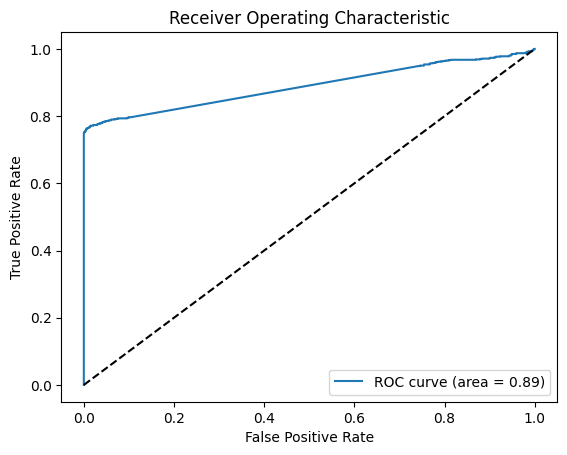

In [75]:
# Gerando CURVA ROC
probs = []
labels = []

model.eval()
with torch.no_grad():
    for inputs, label in test_loader:
        output = model(inputs)
        probs.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

interpretando:
AUC (área sob a curva): no seu gráfico, AUC = 0.89, o que é muito bom.

0.5 = modelo aleatório (linha pontilhada)

1.0 = classificador perfeito

Acima de 0.85 já é considerado um ótimo modelo para muitos contextos

Curva próxima do canto superior esquerdo indica alta sensibilidade (recall) e baixo falso positivo → excelente!

✅ Conclusão:
modelo está muito bem com AUC = 0.89.

O gráfico mostra que há espaço para aumentar recall da classe 1 com pequeno custo de FPR.

Você pode usar o gráfico e o código acima para ajustar o threshold ideal, se desejar melhorar ainda mais.

### Matriz Confusao

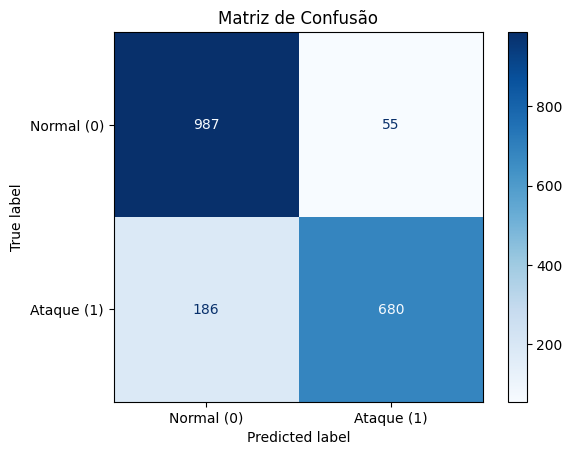

In [76]:
# Matriz de Confusao
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Garantir que estamos no modo de avaliação
model.eval()

# Listas para armazenar rótulos reais e previsões
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > threshold).float()  # Usa threshold da variavel iniciada
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Converter para arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Gerar matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Ataque (1)"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

📌 Interpretação e Observações:
✅ O modelo é forte em identificar "normal" (classe 0), com apenas 55 falsos positivos.

⚠️ Mas há 186 falsos negativos → ataques que o modelo não conseguiu identificar.

Isso pode ser crítico dependendo do domínio da aplicação, já que ataques não detectados são piores que falsos alarmes.

In [77]:
# from sklearn.metrics import f1_score

# thresholds = np.arange(0.3, 0.6, 0.01)
# best_f1 = 0
# best_threshold = 0

# for t in thresholds:
#     preds = (probs > t).astype(float)
#     f1 = f1_score(y_test_tensor, preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = t

# print(f"Melhor threshold: {best_threshold:.2f} com F1-score: {best_f1:.4f}")

Melhor threshold: 0.38 com F1-score: 0.8619


### Identificando Melhor Threshold no conjunto de TESTES

In [78]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Obter scores do modelo no conjunto de teste (probabilidades)
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_probs.extend(outputs.squeeze().tolist())
        all_labels.extend(labels.squeeze().tolist())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# 2. Testar thresholds de 0.1 a 0.9
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
for thresh in thresholds:
    preds = (all_probs >= thresh).astype(float)
    precision = precision_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    results.append((thresh, precision, recall, f1))
    print(f"{thresh:<10.2f} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f}")

Threshold  Precision  Recall     F1-Score  
0.10       0.47       0.98       0.63      
0.15       0.50       0.96       0.66      
0.20       0.93       0.79       0.85      
0.25       0.95       0.78       0.85      
0.30       0.96       0.77       0.86      
0.35       0.97       0.77       0.86      
0.40       0.98       0.77       0.86      
0.45       0.98       0.77       0.86      
0.50       0.98       0.77       0.86      
0.55       0.99       0.76       0.86      
0.60       0.99       0.76       0.86      
0.65       0.99       0.76       0.86      
0.70       0.99       0.76       0.86      
0.75       0.99       0.76       0.86      
0.80       0.99       0.76       0.86      
0.85       0.99       0.76       0.86      
0.90       1.00       0.75       0.86      
0.95       1.00       0.75       0.86      


🎯 Tendo como foco a segurança (detectar o máximo de ataques):
O threshold ideal parece estar entre 0.20 e 0.25:

Recall = 0.78–0.79 → Alta detecção.

Precision = 0.93–0.95 → Poucos falsos positivos.

F1 = 0.85 → Forte equilíbrio.

# RESUMO FINAL

 O processo aplicado foi de regressao logistica com classifica binaria, a principio quando apliquei os dados normalizados com uma rede simples, os valores de LOSS foram extremamente altos na faixa de 28.7365 com 60 épocas, entao na tentativa de melhorar, parti para uma nova arquitetura de rede mais densa, alterando minha classe de rede neural com as seguintes camadas, tendo como fato para um problema de base tabular no meu dataset.

Entrada:     128 neurônios  (input_dim)
Oculta 1:     64 neurônios  (fc1)
Oculta 2:     32 neurônios  (fc2)
Saída:         1 neurônio   (output com sigmoid)

com essas camadas foi possivel checar a um LOSS de 0.28 e ACURACIA de 87.37%, tendo que realizar ajustes finos no LEARNING RATE, THRESHOLD e NUM_EPOCHS. Enfim, mesmo assim o numero de acertos para ataque ainda ficou passivo para se melhorar ainda mais com Recall de 79%, isso fico bem visivel no grafico de matriz de confusao gerado no trabalho.

Enfim, esse trabalho ainda pode ser melhorado para se chegar em percentual mais alto de acertos para ataque, entao fica para os proximos desafios, estuda uma forma de refinar ainda mais essa rede.